<a href="https://colab.research.google.com/github/tatendamawango/Data-Science-and-Artificial-Intelligence/blob/main/Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
df_amazon = pd.read_csv('amazon_electronics_new.csv')

In [ ]:
df_amazon_cleaned = df_amazon.drop(columns=['Unnamed: 0'])
df_amazon_cleaned['timestamp'] = pd.to_datetime(df_amazon_cleaned['timestamp'], unit='s')
df_amazon_cleaned

,userId,productId,Rating,timestamp
0,A132P6YSJSI5G2,0528881469,2.0,2011-02-28
1,A107S4MT25VXQ5,0594481902,5.0,2014-05-08
2,A11E2USO989A37,094339676X,5.0,2013-12-31
3,A1079KKA0AXSL3,0972683275,4.0,2012-01-09
4,A12AU3CNAWYO5D,0972683275,5.0,2012-12-23
...,...,...,...,...
184760,A1244191TGWHXR,B00L4HJCZC,5.0,2014-06-25
184761,A102K65L7Y3X3A,B00L5JFW4E,5.0,2014-07-16
184762,A113Y7U9Q92CZZ,B00L5KRU52,5.0,2014-06-26
184763,A12ARED46EPKIO,B00L5KRU52,4.0,2014-06-26


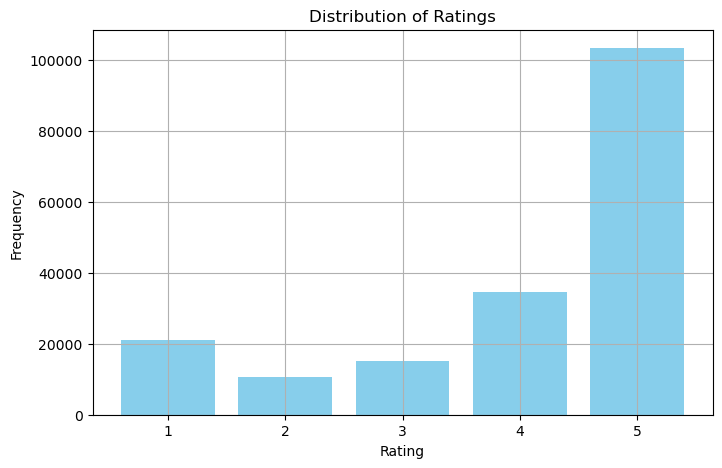

Number of users 100000
Number of products 71431
Product review count
 count    71431.000000
mean         2.586622
std          6.759083
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        448.000000
dtype: float64
User review count
 count    100000.000000
mean          1.847650
std           2.947688
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         252.000000
dtype: float64


(None, None, None, None)

In [ ]:
rating_distribution = df_amazon_cleaned['Rating'].value_counts().sort_index()

num_users = df_amazon_cleaned['userId'].nunique()
num_products = df_amazon_cleaned['productId'].nunique()

product_review_counts = df_amazon_cleaned.groupby('productId').size().describe()
user_review_counts = df_amazon_cleaned.groupby('userId').size().describe()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(rating_distribution.index, rating_distribution.values, color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.grid(True)
plt.show()

print("Number of users", num_users), print("Number of products", num_products), print("Product review count\", product_review_counts), print("User review count\n", user_review_counts)


In [ ]:
!pip install scikit-surprise

Looking in indexes: http://172.17.0.1:3143/root/pypi/+simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.6 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=591469 sha256=8842cf2107264b41157331d2864b3da235f5837ea9a2fe7d5c98249dc9e5a1d3
  Stored in directory: /home/tatmaw/.cache/pip/wheels/79/d0/19/dc3f81d76ebc42f27446d1ab6fc1b102ba53b42b660fa922d6
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_amazon_cleaned[['userId', 'productId', 'Rating']], reader)

trainset, testset = train_test_split(data, test_size=0.25, random_state=42)


sim_options = {'name': 'cosine', 'user_based': False}
algo_knn = KNNBasic(sim_options=sim_options)
algo_knn.fit(trainset)

predictions_knn = algo_knn.test(testset)
rmse_knn = accuracy.rmse(predictions_knn)

rmse_knn

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3784


1.3783749242600019

In [ ]:
from surprise import BaselineOnly

bsl_options = {'method': 'als', 'n_epochs': 5, 'reg_u': 12, 'reg_i': 5}
algo_baseline = BaselineOnly(bsl_options=bsl_options)

algo_baseline.fit(trainset)

predictions_baseline = algo_baseline.test(testset)
rmse_baseline = accuracy.rmse(predictions_baseline)

print(f"RMSE for Baseline model: {rmse_baseline}")


Estimating biases using als...
RMSE: 1.3309
RMSE for Baseline model: 1.3308728487849009


In [ ]:
from surprise import SVD

algo_svd = SVD(n_factors=2, n_epochs=100, biased=True, lr_all=0.001)

algo_svd.fit(trainset)

predictions_svd = algo_svd.test(testset)
rmse_svd = accuracy.rmse(predictions_svd)

print(f"RMSE for SVD model: {rmse_svd}")


RMSE: 1.3281
RMSE for SVD model: 1.3281046267741796


In [ ]:
df_knn = pd.DataFrame(predictions_knn, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_knn['err_knn'] = abs(df_knn['est'] - df_knn['rui'])

df_baseline = pd.DataFrame(predictions_baseline, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_baseline['err_baseline'] = abs(df_baseline['est'] - df_baseline['rui'])

df_svd = pd.DataFrame(predictions_svd, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_svd['err_svd'] = abs(df_svd['est'] - df_svd['rui'])

df_comparison = df_knn[['uid', 'iid', 'err_knn']].merge(
    df_baseline[['uid', 'iid', 'err_baseline']], on=['uid', 'iid']
).merge(
    df_svd[['uid', 'iid', 'err_svd']], on=['uid', 'iid']
)

top_difficult = df_comparison.sort_values(by=['err_knn', 'err_baseline', 'err_svd'], ascending=False).head(10)

top_easy = df_comparison.sort_values(by=['err_knn', 'err_baseline', 'err_svd'], ascending=True).head(10)

print("Top 10 Difficult to Predict")
print(top_difficult)

print("Top 10 Easy to Predict")
print(top_easy)


Top 10 Difficult to Predict
                  uid         iid  err_knn  err_baseline   err_svd
22725  A12QVDHXAQMV6S  B000TYL27M      4.0      3.573029  3.536286
34274  A10YSUEF859U47  B00D029NNA      4.0      3.505737  3.492821
19705  A12X7K54734QXE  B006ZBWV0K      4.0      3.492581  3.520307
15096  A12G8WFVFU2RGO  B004QK7HI8      4.0      3.476040  3.556230
10598  A10BXMCFV2EE8J  B003OC6LWM      4.0      3.402928  3.493331
38134  A12305NG0NSWGP  B003ELVLKU      4.0      3.343854  3.369090
34094  A11R1R20OQK3CE  B003CH77YK      4.0      3.325195  3.307102
10419  A104AB4MW6DQIC  B008UHK3KM      4.0      3.288255  3.361650
35397  A11MFOTM5AOPL3  B004XC6GJ0      4.0      3.244750  3.187946
40662  A113OCKTN00DUW  B008THTOKS      4.0      3.236994  3.335745
Top 10 Easy to Predict
                  uid         iid  err_knn  err_baseline  err_svd
1636   A12G8WFVFU2RGO  B000NMFCIA      0.0           0.0      0.0
3157   A10UHQH1YL5Q6B  B0002L5R78      0.0           0.0      0.0
3593   A12O5SE

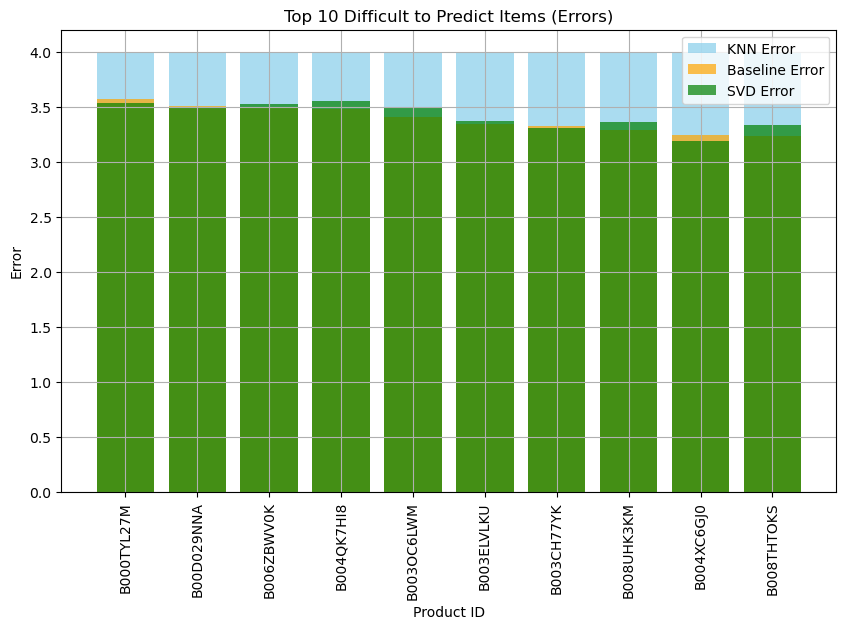

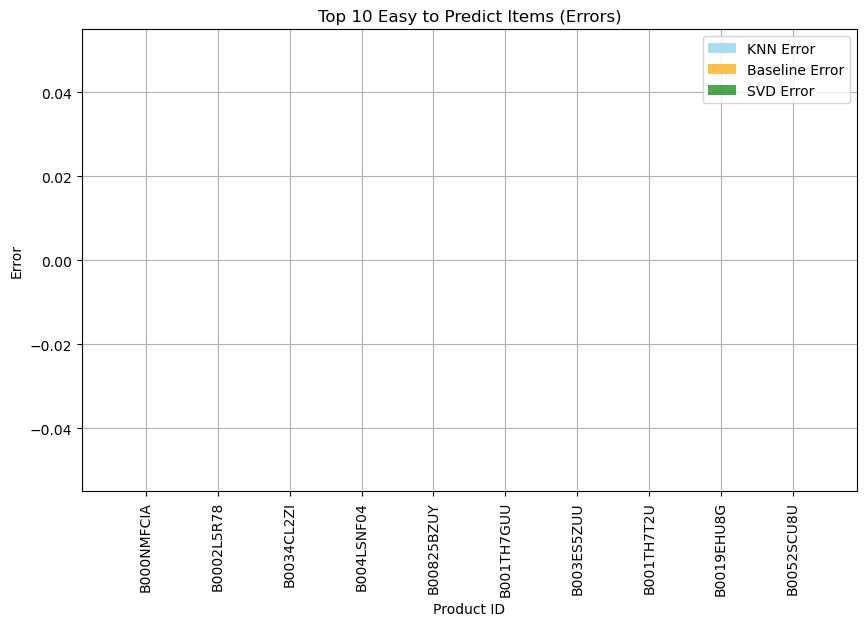

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(top_difficult['iid'], top_difficult['err_knn'], label='KNN Error', color='skyblue', alpha=0.7)
plt.bar(top_difficult['iid'], top_difficult['err_baseline'], label='Baseline Error', color='orange', alpha=0.7)
plt.bar(top_difficult['iid'], top_difficult['err_svd'], label='SVD Error', color='green', alpha=0.7)
plt.xlabel('Product ID')
plt.ylabel('Error')
plt.title('Top 10 Difficult to Predict Items (Errors)')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(top_easy['iid'], top_easy['err_knn'], label='KNN Error', color='skyblue', alpha=0.7)
plt.bar(top_easy['iid'], top_easy['err_baseline'], label='Baseline Error', color='orange', alpha=0.7)
plt.bar(top_easy['iid'], top_easy['err_svd'], label='SVD Error', color='green', alpha=0.7)
plt.xlabel('Product ID')
plt.ylabel('Error')
plt.title('Top 10 Easy to Predict Items (Errors)')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
difficult_items = df_amazon_cleaned[df_amazon_cleaned['productId'].isin(top_difficult['iid'])]
difficult_ratings_distribution = difficult_items['Rating'].value_counts().sort_index()
print(difficult_ratings_distribution)

Rating
1.0     48
2.0     24
3.0     31
4.0     68
5.0    301
Name: count, dtype: int64


In [ ]:
easy_items = df_amazon_cleaned[df_amazon_cleaned['productId'].isin(top_easy['iid'])]
easy_ratings_distribution = easy_items.groupby('userId').size().describe()
print(easy_ratings_distribution)

count    1146.000000
mean        1.032286
std         0.195597
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
dtype: float64


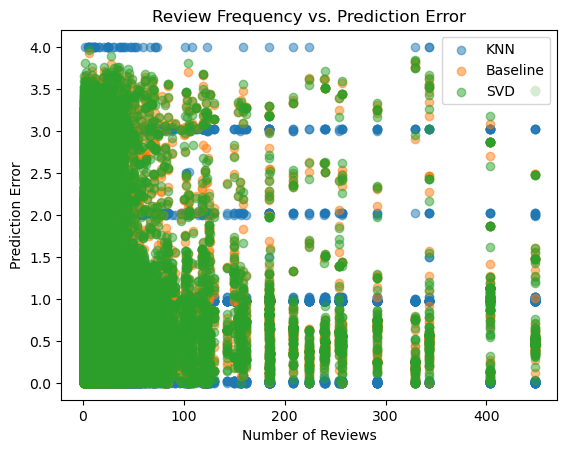

In [ ]:
df_comparison['num_reviews'] = df_comparison['iid'].map(df_amazon_cleaned['productId'].value_counts())
plt.scatter(df_comparison['num_reviews'], df_comparison['err_knn'], alpha=0.5, label='KNN')
plt.scatter(df_comparison['num_reviews'], df_comparison['err_baseline'], alpha=0.5, label='Baseline')
plt.scatter(df_comparison['num_reviews'], df_comparison['err_svd'], alpha=0.5, label='SVD')
plt.xlabel('Number of Reviews')
plt.ylabel('Prediction Error')
plt.title('Review Frequency vs. Prediction Error')
plt.legend()
plt.show()

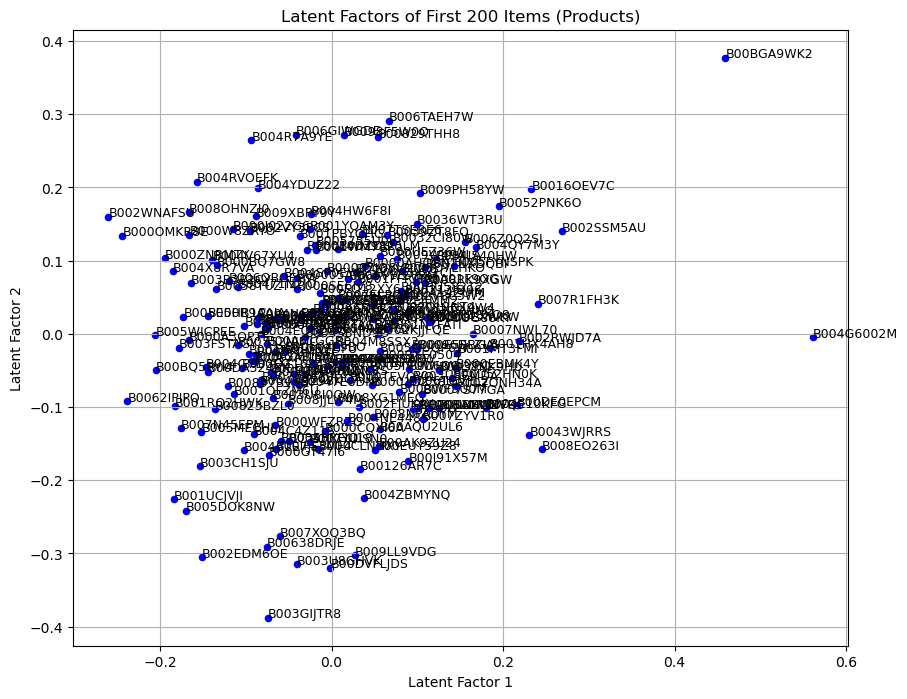

In [ ]:
from sklearn.decomposition import PCA

item_factors = algo_svd.qi

pca = PCA(n_components=2)
item_factors_2d = pca.fit_transform(item_factors)

plt.figure(figsize=(10, 8))
plt.scatter(item_factors_2d[:200, 0], item_factors_2d[:200, 1], s=20, c='blue')
for i in range(200):
    plt.text(item_factors_2d[i, 0], item_factors_2d[i, 1], trainset.to_raw_iid(i), fontsize=9)
plt.title('Latent Factors of First 200 Items (Products)')
plt.xlabel('Latent Factor 1')
plt.ylabel('Latent Factor 2')
plt.grid(True)
plt.show()


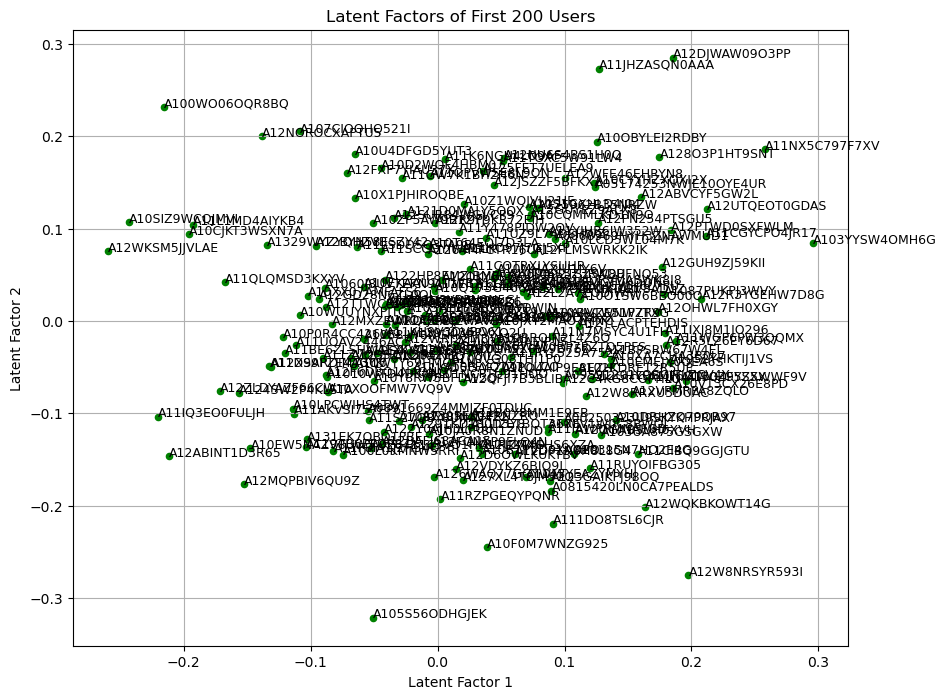

In [ ]:
user_factors = algo_svd.pu  # latent factors for users

user_factors_2d = pca.fit_transform(user_factors)

plt.figure(figsize=(10, 8))
plt.scatter(user_factors_2d[:200, 0], user_factors_2d[:200, 1], s=20, c='green')
for i in range(200):
    plt.text(user_factors_2d[i, 0], user_factors_2d[i, 1], trainset.to_raw_uid(i), fontsize=9)
plt.title('Latent Factors of First 200 Users')
plt.xlabel('Latent Factor 1')
plt.ylabel('Latent Factor 2')
plt.grid(True)
plt.show()